In [594]:
def leftmost(points):
    leftMostIndex = 0
    for i in range(1,len(points)):
        if points[i][0] < points[leftMostIndex][0]:
            leftMostIndex = i
        elif points[i][0] == points[leftMostIndex][0]:
            if points[i][1] > points[leftMostIndex][1]:
                leftMostIndex = i
    return leftMostIndex

In [595]:
def direction(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) \
        -(p2[1] - p1[1]) * (p3[0] - p1[0])

In [596]:
def squaredDistance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    dx = x2 - x1
    dy = y2 - y1
    distance_squared = dx**2 + dy**2
    return distance_squared

In [597]:
def giftWrapping(points):
    # find the leftmost point
    leftmostIndex = leftmost(points)
    leftmostPoint = points[leftmostIndex]

    # selection sort
    l = leftmostIndex
    hull = []
    hull.append(leftmostPoint)
    while (True):
        q = (l+1) % len(points)
        for i in range(len(points)):
            if i == l:
                continue
            # find the greates left turn
            # in case of collinearity, consider the farthest point
            d = direction(points[l], points[i], points[q])
            if d > 0 or (d == 0 and squaredDistance(points[i], points[l]) > squaredDistance(points[q], points[l])):
                q = i
            
        l = q
        if l == leftmostIndex:
            break
        hull.append(points[q])   

    return hull

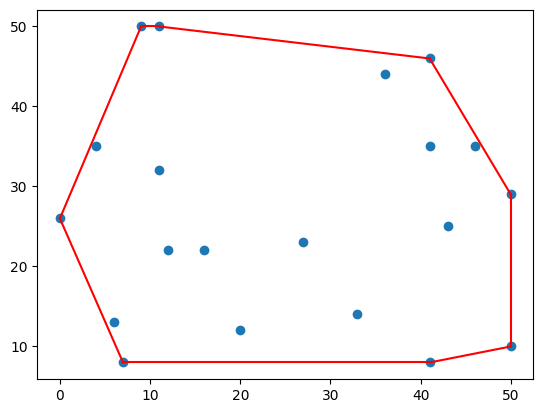

In [598]:
from matplotlib import pyplot as plt #for plotting
from random import randint #for creating data points

def create_points(ct, min = 0, max = 50):
    return [[randint(min, max), randint(min, max)]\
        for _ in range(ct)] 

def scatter_plot(coords, convex_hull = None):
    xs, ys = zip(*coords) #unzip into x and y coordinates
    plt.scatter(xs, ys)

    if convex_hull:
        for i in range(1, len(convex_hull) + 1):
            if i == len(convex_hull): i = 0 #wrap
            c0 = convex_hull[i-1]
            c1 = convex_hull[i]
            plt.plot((c0[0], c1[0]), (c0[1], c1[1]), 'r')
    plt.show()
    
points = create_points(20)
hull = giftWrapping(points)

scatter_plot(points, hull)